![logo](images/logo.png)

---
#### DESCRIPCIÓN DE LOS DATOS
---

En primer lugar vamos a leer un dataset con eventos de cada uno de los usos finales del agua.

Este dataset contiene eventos pertenecientes a estos 6 usos finales:

* Grifos
* Cisternas
* Duchas
* Fugas
* Lavadora
* Lavavajillas

De cada evento se han extraido 37 variables.

El fichero está en format CSV, a continuación se suminastra una función que permite cargarla.

---


In [5]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import Normalizer

np.random.seed(12)

def ReadEvents(file):
    data = np.loadtxt(file,skiprows=1,delimiter=';',usecols=range(0,37))
    labels = np.loadtxt(file,skiprows=1,delimiter=';',usecols=(37,),dtype='str')
    
    (nSamples,nFeatures)=data.shape
    randomPermutation = np.random.permutation(nSamples)
    data=data[randomPermutation,:]
    labels=labels[randomPermutation]
    le = preprocessing.LabelEncoder()
    le.fit(np.unique(labels))
    labels = le.transform(labels)
    return data,labels,le

(data,labels,le) = ReadEvents('dataset/dataset_eventos.csv')



---
#### TSNE para entender la complejidad del problema
---

Vamos a comprobar la dificultad del problema al que nos enfrentamos. Para ello vamos a utilizar el algoritmo de visualización t-SNE.

Es un algoritmo que permite reducir datasets con un número elevado de dimensiones a únicamente dos dimensiones, con lo que se puede visualizar cómo de complejo es clasificar un dataset.

En la siguiente imágen se puede ver un ejemplo del algoritmo t-SNE con la base de datos MNIST:

<img src="images/tsne-mnist.png" width="300">

Vamos a ejecutar el algoritmo sobre un conjunto de variables de nuestro dataset para ver la dificultad de nuestro problema.

Podrá observar que la principal dificultad radica en el consumo de grifos, que debido a su gran variabilidad puede confundirse con cualquier otro.

---


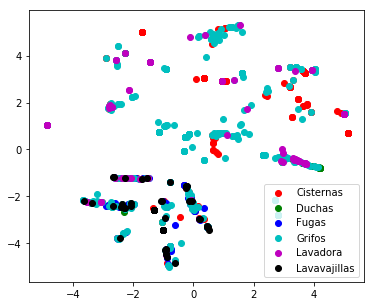

In [6]:
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE

(data,labels,le) = ReadEvents('dataset/dataset_eventos.csv')

target_ids=range(1+np.max(labels))
class_names = le.inverse_transform(range(1+np.max(labels)))

normalizador = Normalizer()
data = data[:,[2,9,0,6,4,10,1,7,3]]
data=normalizador.fit_transform(data)

tsne = TSNE(n_components=2, learning_rate=0.05)

X_2d = tsne.fit_transform(data[0:1000,:])

plt.figure(figsize=(6, 5))

colors = 'r', 'g', 'b', 'c', 'm', 'k'
for i, c, label in zip(target_ids, colors, class_names):
    plt.scatter(X_2d[labels[0:1000] == i, 0], X_2d[labels[0:1000] == i, 1], c=c, label=label)
plt.legend()
plt.show()


---
#### ALGORITMO 1.MODELO LINEAL, Regresión logística
---

En primer lugar vamos a probar el clasificador conocido como regresión logística. Es un modelo lineal que se encuentra implementado en la librería sklearn.

<img src="images/linear.jpg" width="350" />

Su principal hiperparámetro es el asociado a la regularización (parámetro C en la inicialización).

La función LogistricRegressionCV se encarga de hacer la validación cruzada por nosotros:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

Siga los siguientes pasos:

* Entrene el algoritmo probando los valores C=10^n donde n puede tomar los valores {-4,-3,-2,-1,0,1,2,3,4}
* Obtenga el accuracy sobre el conjunto de test.

---

In [8]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

# Vamos a leer los eventos del fichero
(data,labels,le) = ReadEvents('dataset/dataset_eventos.csv')

##########################################################################################
# Divida el conjunto de datos en un conjunto de entrenamiento y test.
# Deje el 70% de los datos en el conjunto de entrenamiento y el 30% restante en el de test
# Puede hacer uso de la función train_test_split de sklearn
##########################################################################################

x_train, x_test, y_train, y_test = train_test_split(data,labels, test_size=0.3)

##########################################################################################
# Utilice el algoritmo LogisticRegressionCV de sklearn para hacer la validación cruzada
# del parámetro C del algoritmo. Puede encontrar aquí información sobre la función 
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
##########################################################################################

cs=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

modelo = LogisticRegressionCV(cv=5, Cs=cs, multi_class='multinomial').fit(x_train, y_train)

###########################################################################################
# Utilice el modelo lineal para clasificar el conjunto de test y obtenga la accuracy.
###########################################################################################

preds = modelo.predict(x_test)
accuracy = accuracy_score(y_test,preds) 

print("Accuracy",accuracy)



Accuracy 0.4945388349514563


---
#### ALGORITMO 2.MÉTODOS DE NÚCLEO, SVM No lineal
---

Finalmente vamos a probar un modelo no lineal conocido como máquinas de vectores soporte (SVMs), vamos a utilizar como función de kernel una función de base radial ('rbf'). 

<img src="images/svm.png" width="350" />

También se encuentra en la librería sklearn:

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

En este caso tenemos dos hiperparámetros a validar. El parámetro de regularización (llamado C) y la anchura de la función de kernel rbf (llamado gamma). 

La función GridSearchCV nos facilitará la validación cruzada:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Siga los siguientes pasos:

1. Utilice el comando GridSearchCV para obtener los mejores parámetros de C y gamma (pruebe los valores 1, 10 y 100). 

2. Obtenga las prestaciones sobre el conjunto detest.

3. Repita el ejercicio utilizando únicamente las variables [2,9,0,6,4,10,1,7,3]

---


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


(data,labels,le) = ReadEvents('dataset/dataset_eventos.csv')
x_train, x_test, y_train, y_test = train_test_split(data,labels, test_size=0.3)



x_train=x_train[:,[2,9,0,6,4,10,1,7,3]]
x_test=x_test[:,[2,9,0,6,4,10,1,7,3]]

######################################################################################
# Nomalice el conjunto de datos para que las vairables tengan media 0 y varianza 1
# Puede hacer uso de la función Normalizer de sklearn.
#######################################################################################
normalizador = Normalizer()
x_train=normalizador.fit_transform(x_train)
x_test=normalizador.transform(x_test)


######################################################################################
# Hago uso de la función GridSearchCV para entrenar una SVM
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# Explore los valores de C=1, 10, 100 y gamma=1,10,100 
######################################################################################

Cs = [1, 10, 100]
gammas = [1,10,100]
param_grid = {'C': Cs, 'gamma' : gammas}
svm_classifier = GridSearchCV(SVC(kernel='rbf',cache_size=4000), param_grid, cv=StratifiedKFold(n_splits=5),n_jobs=4,verbose=2)
svm_classifier.fit(x_train, y_train)

###########################################################################################
# Utilice la SVM para clasificar el conjunto de test y obtenga la accuracy.
###########################################################################################


predictions=svm_classifier.predict(x_test)
Accuracy = accuracy_score(predictions,y_test)

print("Final Accuracy:", Accuracy)

###############################################################################################
# No se observa mejora respecto al modelo lineal. El motivo es que a la SVM le afectan muy negativamente
# varaibles que no aportan información.
# Repita el ejercicio seleccionando las variables (columnas) [2,9,0,6,4,10,1,7,3]
################################################################################################


                        


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=1, gamma=1 ....................................................
[CV] C=1, gamma=1 ....................................................
[CV] C=1, gamma=1 ....................................................
[CV] C=1, gamma=1 ....................................................
[CV] ..................................... C=1, gamma=1, total=   1.2s
[CV] C=1, gamma=1 ....................................................
[CV] ..................................... C=1, gamma=1, total=   1.2s
[CV] C=1, gamma=10 ...................................................
[CV] ..................................... C=1, gamma=1, total=   1.2s
[CV] C=1, gamma=10 ...................................................
[CV] ..................................... C=1, gamma=1, total=   1.2s
[CV] C=1, gamma=10 ...................................................
[CV] .................................... C=1, gamma=10, total=   1.1s
[CV] C=1, gamma=1

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   16.3s


[CV] ................................... C=100, gamma=1, total=   1.3s
[CV] C=100, gamma=10 .................................................
[CV] .................................. C=100, gamma=10, total=   1.8s
[CV] C=100, gamma=10 .................................................
[CV] .................................. C=100, gamma=10, total=   1.7s
[CV] C=100, gamma=100 ................................................
[CV] .................................. C=100, gamma=10, total=   1.6s
[CV] C=100, gamma=100 ................................................
[CV] .................................. C=100, gamma=10, total=   1.6s
[CV] C=100, gamma=100 ................................................
[CV] .................................. C=100, gamma=10, total=   1.7s
[CV] C=100, gamma=100 ................................................
[CV] ................................. C=100, gamma=100, total=   1.7s
[CV] C=100, gamma=100 ................................................
[CV] .

[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   23.1s finished


Final Accuracy: 0.6462378640776699


---
#### ALGORITMO 3. REDES NEURONALES, Perceptrón Multicapa
---


El tercer algoritmo que vamos a probar es una red neuronal. Para ello vamos a hacer uso de dos librerías de Python:

[Tensorflow](https://www.tensorflow.org/?hl=es)

[Keras](https://keras.io/)


#### DEFINICIÓN DE LA RED NEURONAL


Imaginemos que necesitamos implementar la red neuronal de la siguiente figura (capa de entrada 37 neuronas, primera capa oculta 4 neuronas, segunda capa oculta 3 neuronas, capa de salida 6 neuronas (una por cada uso de agua):

<img src="images/MLP.png" alt="mnist" width="500"/>

Con la librería keras, es muy sencillo, vamos a emplear un modelo secuencial donde las capas de neuronas se van añadiendo una a una. Para un perceptrón multicapa tenemos que ir añadiendo capas de tipo Dense (conectan todas las neuronas de la capa anterior con la capa siguiente, se indica el númeor de neuronas de la siguiente capa y la función de activación que aplican):

```Python
from keras.models import Sequential
from keras.layers import Dense, Activation

# Instanciamos la red neuronal
model = Sequential()

# Añadimos la primera capa oculta, numero de neuronas y función de activación.
# NOTA: En la primera capa tenemos que indicar el tamaño de los datos de entrada.
model.add(Dense(100, input_shape=(37,), activation='tanh'))

# Añadimos la primera capa oculta, numero de neuronas y función de activación.
model.add(Dense(6, activation='softmax'))
```

**Recuerde que para la capa de salida:**

* Para problemas de regresión (la salida es una variable continua) no debe aplicar ninguna función de activación. 
* Para problemas de clasificación, donde hay varias categorías de clasificación y un dato solo puede pertenecer a una de las clases, entonces debe haber tantas neuronas como clases y la función de activación de la capa de salida debe ser softmax para indicar que queremos probabilidades y que la suma de ellas debe ser igual a uno. 
* Para problemas de clasificación multiclase, donde hay varias categorías y un dato puede pertenecer a la vez a varias de ellas, debe aplicarse una función de activación sigmoide. 

#### DEFINICIÓN DE LA FUNCIÓN DE COSTE Y EL ALGORITMO DE OPTIMIZACIÓN

El siguiente paso es definir la función de coste, el algoritmo de optimización y la información que deseamos que se muestre por pantalla durante el entrenamiento. Todo eso se hace utilizando una única línea de código.

**Para las funciones de coste, recuerde de la teoría que hemos visto que:**

* Para clasificación multiclase donde los datos pueden pertenecer a una única clase se utiliza (este es nuestro caso): 'categorical_crossentropy'
* Para clasificación multiclase donde los datos pueden pertenecer a varias categorías se utiliza: 'binary_crossentropy'
* Para regresión se utilizan funciones como: 'mean_squared_error', 'mean_absolute_error'

**Respecto al algoritmos de optimización:**

* Hay muchas alternativas, cada una tiene sus ventajas e inconvenientes y no es posible conocer de antemano el mejor algoritmo de optimización. Aquí tiene algunos ejemplos visuales para mostrar cómo algunos funcionan mejor o peor dependiendo de la situación a la hora de encontrar el mínimode la función de coste:

<table>
   <tr>
  <td><img src="images/1.gif" width="200"/></td><td><img src="images/4.gif" width="200" /></td>
  </tr>     
       <tr>
  <td><img src="images/2.gif" width="200"/></td><td><img src="images/3.gif" width="200" /></td>
  </tr>     

</table>

**Respecto a la información a mostrar por pantalla:**
Lo normal en problemas de clasificación como el que vamos a tratar es mostrar el ratio de (aciertos)/(número total de datos). Aquí puede encontrar información sobre más métricas, puedeseleccionar más de una:
[https://keras.io/metrics/]( https://keras.io/metrics/)

**Aquí tiene un ejemplo de cómo se define:**

```Python
model.compile(loss='categorical_crossentropy',
              optimizer=nadam,
              metrics=['accuracy'])
```

---

In [12]:

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense, Activation
from keras.models import Sequential
from keras.optimizers import Nadam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

###################################################################################
# Cargamos el dataset y dividimos en conjunto de entrenamiento y test
###################################################################################
(data,labels,le) = ReadEvents('dataset/dataset_eventos.csv')
x_train, x_test, y_train, y_test = train_test_split(data,labels, test_size=0.3)

###################################################################################
# Normalizamos con un min max scaler
###################################################################################
normalizer = MinMaxScaler(feature_range=(0, 0.1))
x_train=normalizer.fit_transform(x_train)
x_test=normalizer.transform(x_test)

###################################################################################
# Vamos a validar la tasa de aprendizaje, creamos los conjuntos de validación y 
# el rango de valores del learning rate que vamos a probar
###################################################################################
Xcvtr, Xcvtst, Ycvtr, Ycvtst = train_test_split(x_train,y_train, test_size=0.3)
lrates = [0.0001, 0.001,0.01]
   

BestAccuracy=-1.0
BestC = -1
BestG = -1


###################################################################################
# Ponemos las etiquetas en el formato correcto
###################################################################################

Ycvtr = np.eye(6)[np.int_(Ycvtr)]
Ycvtst = np.eye(6)[np.int_(Ycvtst)]
y_test = np.eye(6)[np.int_(y_test)]
y_train = np.eye(6)[np.int_(y_train)]

###################################################################################
# Iteramos sobre los valores de la tasa de aprendizaje
###################################################################################

for l in lrates:
    print("Training parameters: lrate=",l)
    
    ###################################################################################
    # Define aquí con keras la red neuronal a utilizar
    # Puedes jugar con el número de capas y con las neuronas en cada capa para tratar
    # de alcanzar la mayor prestación posible
    ###################################################################################
    
    n_epoch = 40
    batch_size = 16
    input_dim = 37
    hidden = 300
    output = 6  

    model = Sequential()
    model.add(Dense(hidden,input_dim=input_dim,init='lecun_uniform',activation='relu'))
    model.add(Dense(hidden,init='lecun_uniform',activation='relu'))
    model.add(Dense(output_dim=6,init='lecun_uniform'))
    model.add(Activation('softmax'))
    decay = l/n_epoch

    nadam = Nadam(lr=l)
    model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
    model.fit(Xcvtr, Ycvtr, nb_epoch=n_epoch, shuffle=True, batch_size=batch_size,validation_data=(Xcvtst, Ycvtst))
            
    predictions = model.predict(Xcvtst)
    predictions =np.argmax(predictions,axis=1)
    labelsTest = np.argmax(Ycvtst,axis= 1)
    Accuracy = accuracy_score(predictions,labelsTest)
            
            
    if(Accuracy> BestAccuracy):
        BestAccuracy = Accuracy
        BestLRate = l
                

    print("Right Now Best Accuracy CV:",BestAccuracy, "LRate:", BestLRate)

###################################################################################
# VUELVA A DEFINIR AQUÍ LA RED NEURONAL
###################################################################################    
model = Sequential()
model.add(Dense(hidden,input_dim=input_dim,init='lecun_uniform',activation='relu'))
model.add(Dense(hidden,init='lecun_uniform',activation='relu'))
model.add(Dense(output_dim=6,init='lecun_uniform'))
model.add(Activation('softmax'))
nadam = Nadam(lr=BestLRate)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
model.fit(x_train, y_train, nb_epoch=n_epoch, shuffle=True, batch_size=batch_size)


###################################################################################
# EVALUAMOS AHORA SOBRE EL CONJUNTO DE TEST
###################################################################################  
predictions = model.predict(x_test)
predictions =np.argmax(predictions,axis=1)
labelsTest = np.argmax(y_test,axis= 1)
Accuracy = accuracy_score(predictions,labelsTest)
print("Accuracy:",Accuracy)


Using TensorFlow backend.


Training parameters: lrate= 0.0001
Train on 5381 samples, validate on 2307 samples
Epoch 1/40
5381/5381 [==============================] - 1s 205us/step - loss: 1.5372 - acc: 0.4746 - val_loss: 1.4154 - val_acc: 0.4764
Epoch 2/40
5381/5381 [==============================] - 1s 108us/step - loss: 1.3888 - acc: 0.4789 - val_loss: 1.3662 - val_acc: 0.4764
Epoch 3/40
5381/5381 [==============================] - 1s 108us/step - loss: 1.3297 - acc: 0.4804 - val_loss: 1.3018 - val_acc: 0.4803
Epoch 4/40
5381/5381 [==============================] - 1s 108us/step - loss: 1.2670 - acc: 0.4895 - val_loss: 1.2445 - val_acc: 0.5054
Epoch 5/40
5381/5381 [==============================] - 1s 108us/step - loss: 1.2132 - acc: 0.5088 - val_loss: 1.1964 - val_acc: 0.5085
Epoch 6/40
5381/5381 [==============================] - 1s 110us/step - loss: 1.1704 - acc: 0.5174 - val_loss: 1.1629 - val_acc: 0.5106
Epoch 7/40
5381/5381 [==============================] - 1s 110us/step - loss: 1.1370 - acc: 0.5241 - 

---
#### ALGORITMO 4. ÁRBOLES, XGBOOST
---

Tradicionalmente Random Forest ha sido muy utilizado para trabajar con datos que combinan variables continuas con categóricas. Recientemente, otro algoritmo ha pasado a dominar este tipo de problemas: Gradient Boosted Trees.

Al igual que RF, GBT clasifica ejemplos mediante el uso de un conjunto de árboles de decisión. En el caso de este segundo, los árboles se construyen secuencialmente, añadiendo en cada iteración el árbol que mejor compense por los errores de los árboles ya existentes. Se le llama método de gradiente porque el modelo evoluciona en dirección al menor error, árbol a árbol.

<img src="images/tree.png" width="350" />

La librería que vamos a utilizar es XGBoost, una implementación de GBT compatible con Python y R. Su éxito en competiciones se debe no solo a su precisión, sino también a la velocidad de iteración que permite. Aún trabajando con un solo core, funciona dos veces más rápido que la biblioteca gbm de R y cuatro veces más rápido que la implementación de scikit-learn en Python. Esto se consigue mediante una serie de optimizaciones en la implementación, que pueden acelerarse aún más gracias a su compatibilidad con sistemas distribuidos, como por ejemplo MPI y Yarn.

Sus principales parámetros a validar son la profundidad de los árboles (parámetro max_depth en la inicialización) y el número de árboles (n_estimators). Para entrenar un modelo se utiliza la siguiente secuencia de comandos:

```python
from xgboost import XGBClassifier

xgbclassifier=XGBClassifier(max_depth=..., n_estimators=..., learning_rate=0.05,subsample=0.9,verbose=2)
xgbclassifier.fit(Xcvtr,Ycvtr)

```
Para hacer predicciones se utiliza el comando predict al igual que en algoritmos anteriores.

Siga los siguientes pasos:

1. Valide los parámetros max_depth probando los valores 3, 7, 11 y el valor n_estimators probando los valores 10, 25 y 100. 

2. Una vez conocido el mejor valor de los hiperparámetros, entrene el algoritmo utilizando la totalidad del conjunto de entrenamiento.

3. Obtenga el accuracy sobre el conjunto de test.

---


In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


(data,labels,le) = ReadEvents('dataset/dataset_eventos.csv')

############################################################################
# Dividimos el conjunto de datos en un conjunto de entrenamiento y otro de test
#############################################################################

x_train, x_test, y_train, y_test = train_test_split(data,labels, test_size=0.3)


############################################################################
# Para hacer la validación, vamos a dividir el conjunto de entrenamiento en dos
#############################################################################

Xcvtr, Xcvtst, Ycvtr, Ycvtst = train_test_split(x_train,y_train, test_size=0.25)


#############################################################################
# Complete el rango de parámetros que vamos a validar
#############################################################################
depths=np.array([3,7,11, 15])
estimators=np.array([10,100,200])

BestAccuracy=-1.0
BestC = -1
BestG = -1
    
BestAccuracy=-1.0
BestEstimator=-1.0

    
for depth in depths:
    for estimator in estimators:    
        
        print("Training parameters: depth=",depth, "estimators=",estimator)
        
        
        #############################################################################
        # Entrenamos el algoritmo utilizando como entrenamiento el subconjunto Xcvtr
        #############################################################################    
        xgbclassifier=XGBClassifier(max_depth=depth, n_estimators=estimator, learning_rate=0.05,subsample=0.9,verbose=2)
        xgbclassifier.fit(Xcvtr,Ycvtr)

        #############################################################################
        # Evaluamos sobre el conjunto Xcvtst
        #############################################################################
        predictions=xgbclassifier.predict(Xcvtst)
        Accuracy = accuracy_score(predictions,Ycvtst)

        if(Accuracy> BestAccuracy):
            BestAccuracy = Accuracy
            BestDepth = depth
            BestEstimator = estimator
                
        print("Right Now Best Accuracy CV:",BestAccuracy, "Depth:", BestDepth)


#############################################################################
# Finalmente, una vez conocidos los hiperparámetros,
# reentrenamos utilizando todo el conjuto de entrenamiento
#############################################################################        

xgbclassifier = XGBClassifier(max_depth=BestDepth, n_estimators=BestEstimator, learning_rate=0.05,subsample=0.9,verbose=2)
xgbclassifier.fit(x_train,y_train)

#############################################################################
# Y evaluamos el modelo en el conjunto de test
#############################################################################        

predictions=xgbclassifier.predict(x_test)
Accuracy = accuracy_score(predictions,y_test)

print("Final Accuracy:",Accuracy)        
        

Training parameters: depth= 3 estimators= 10
Right Now Best Accuracy CV: 0.7200832466181062 Depth: 3
Training parameters: depth= 3 estimators= 100
Right Now Best Accuracy CV: 0.7793964620187305 Depth: 3
Training parameters: depth= 3 estimators= 200
Right Now Best Accuracy CV: 0.8111342351716961 Depth: 3
Training parameters: depth= 7 estimators= 10
Right Now Best Accuracy CV: 0.8111342351716961 Depth: 3
Training parameters: depth= 7 estimators= 100
Right Now Best Accuracy CV: 0.8459937565036421 Depth: 7
Training parameters: depth= 7 estimators= 200
Right Now Best Accuracy CV: 0.8590010405827263 Depth: 7
Training parameters: depth= 11 estimators= 10
Right Now Best Accuracy CV: 0.8590010405827263 Depth: 7
Training parameters: depth= 11 estimators= 100
Right Now Best Accuracy CV: 0.8621227887617066 Depth: 11
Training parameters: depth= 11 estimators= 200
Right Now Best Accuracy CV: 0.8621227887617066 Depth: 11
Training parameters: depth= 15 estimators= 10
Right Now Best Accuracy CV: 0.8621